# 2. Leaky Aquifer Recovery Test - Hardixveld Example
**This test is taken from MLU examples.**

## Introduction and Conceptual Model

This test was taken in Hardinxveld-Giessendam, Netherlands, in 1981 to quantify the head-loss at each pumping well by clogging and to assess the transmissivity variation in the area.

The hydrogeological conceptualization can be described as the following:
* The first ten meters depth is an aquitard
* Followed by the first aquifer from 10 to 37 m depth, this is also the test aquifer.
* A new aquitard is present from 37 m depth to 68 m depth
* A final aquifer is from 68 to 88 m depth.
* Below 88 m depth the formations are considered an aquiclude

Five pumping wells are screened in the first aquifer. The drawdown of one of them is available in the MLU documentation (Carlson & Randall, 2012).
The provided pumping well was operated for 20 minutes at 1848 m3/d. Drawdown was recorded for a total of 50 minutes during and after pumping. The radius of the pumped well is 0.155 m.

In this notebook, we reproduce the work of Xinzhu (2020) and demonstrate the use of TTim to fit a recovery test and quantify the skin resistance in the well and the hydraulic parameters of the aquifer.

The following figure summarises the hydrogeological conceptual model.

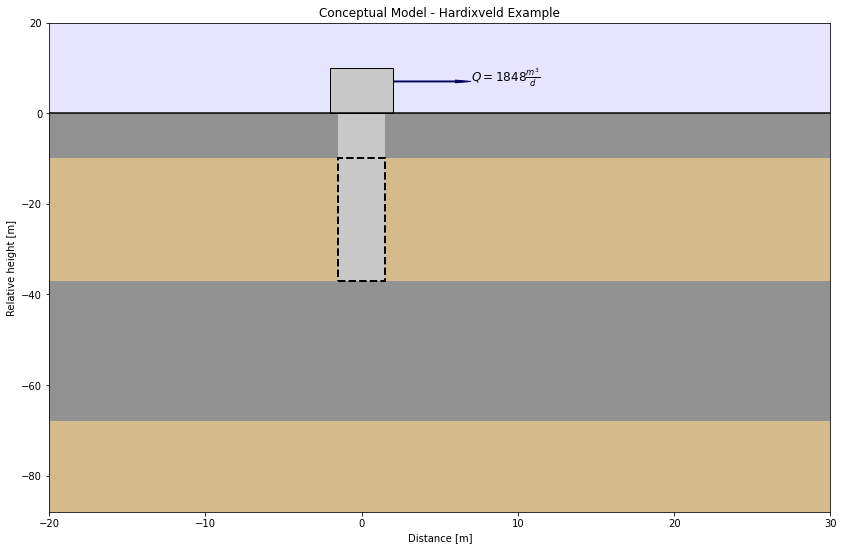

In [1]:
import matplotlib.pyplot as plt
import numpy as np

##Now printing the conceptual model figure:

fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(1,1,1)
#sky
sky = plt.Rectangle((-20,0), width = 50, height = 20, fc = 'b', zorder=0, alpha=0.1)
ax.add_patch(sky)

#Aquifer:
ground = plt.Rectangle((-20,-37), width = 50, height = 27, fc = np.array([209,179,127])/255, zorder=0, alpha=0.9)
ax.add_patch(ground)

#Aquifer 2:
ground2 = plt.Rectangle((-20,-88), width = 50, height = 20, fc = np.array([209,179,127])/255, zorder=0, alpha=0.9)
ax.add_patch(ground2)

#Confining bed:
confining_unit = plt.Rectangle((-20,-10), width = 50, height = 10, fc = np.array([100,100,100])/255, zorder=0, alpha=0.7)
ax.add_patch(confining_unit)

confining_unit2 = plt.Rectangle((-20,-68), width = 50, height = 31, fc = np.array([100,100,100])/255, zorder=0, alpha=0.7)
ax.add_patch(confining_unit2)

well = plt.Rectangle((-1.5,-37), width = 3, height = 37, fc = np.array([200,200,200])/255, zorder=1)
ax.add_patch(well)

#Wellhead
wellhead = plt.Rectangle((-2,0),width = 4, height = 10, fc = np.array([200,200,200])/255, zorder=2, ec='k')
ax.add_patch(wellhead)

#Screen for the well:
screen = plt.Rectangle((-1.5,-37), width = 3, height = 27, fc = np.array([200,200,200])/255, alpha=1, zorder = 2, ec = "k", ls = '--')
screen.set_linewidth(2)
ax.add_patch(screen)
pumping_arrow = plt.Arrow(x = 2,y = 7, dx = 5, dy = 0, color = "#00035b")
ax.add_patch(pumping_arrow)
ax.text(x = 7, y = 7, s = r'$ Q = 1848 \frac{m^3}{d}$', fontsize = 'large' )

#last line
line = plt.Line2D(xdata= [-200,1200], ydata = [0,0], color = "k")
ax.add_line(line)


ax.set_xlim([-20,30])
ax.set_ylim([-88,20])
ax.set_xlabel('Distance [m]')
ax.set_ylabel('Relative height [m]')
ax.set_title('Conceptual Model - Hardixveld Example');

## Step 1. Import required libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ttim import *
import pandas as pd

## Step 2. Set basic parameters for the model

In [3]:
H = 27 #aquifer thickness [m]
zt = -10 #upper boundary of aquifer
zb = zt - H #lower boundary of the aquifer
rw = 0.155 #well screen radius [m]
Q = 1848 #constant discharge rate [m^3/d]
t0 =  0.013889 #time stop pumping [d]

## Step 3. Load data for the recovery test

Data is saved in a text file where the first column is the time data in days and in the second is the drawdown in m

In [4]:
data = np.loadtxt('data/recovery.txt', skiprows=1)
t = data[:, 0]
h = data[:, 1]

## Step 4. Create the first conceptual model

Here we create a two aquifer leaky model in ModelMaq, so we have to define the top of the first aquitard layer, followed by the tops and bottoms of the aquifer layers. Here we ignore storage (```Sll```) of the aquitard layers.

The well is defined with skin resistance (```res```) and the pumping schedule with the start and shutdown of the pump.

More details on model construction and theory can be seen in:

- [Confined 1 - Oude Korendijk](confined1_oude_korendijk)
- [Confined 4 - Schroth](confined4_schroth.ipynb)
- [Leaky 1 - Dalem](leaky1_dalem.ipynb)

In [5]:
ml1 = ModelMaq(kaq=[50, 40], z=[0, zt, zb, -68, -88], c=[1000, 1000], Saq=[1e-4, 5e-5],\
              topboundary='semi', tmin=1e-4, tmax=0.04)
w1 = Well(ml1, xw=0, yw=0, rw=rw, res=1, tsandQ=[(0, Q), (t0, 0)], layers=0)
ml1.solve()

self.neq  1
solution complete


## Step 5. Calibration

The parameters to be calibrated are the hydraulic conductivity and specific storage of the first layer, and the skin resistance of the well. The parameters of the aquitards and the second aquifer are kept fixed.

More details on the calibration procedure and theory can be seen in:

- [Confined 1 - Oude Korendijk](confined1_oude_korendijk)

In [6]:
ca1 = Calibrate(ml1)
ca1.set_parameter(name='kaq0', initial=50, pmin=0)
ca1.set_parameter(name='Saq0', initial=1e-4, pmin=0)
ca1.set_parameter_by_reference(name='res', parameter=w1.res[:], initial=1, pmin=0)
ca1.seriesinwell(name='obs', element=w1, t=t, h=h)
ca1.fit()

..............................................................................................................................................................................................................................................................................................................................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 331
    # data points      = 35
    # variables        = 3
    chi-square         = 0.00106334
    reduced chi-square = 3.3229e-05
    Akaike info crit   = -358.059006
    Bayesian info crit = -353.392962
[[Variables]]
    kaq0:  44.5287657 +/- 0.66007100 (1.48%) (init = 50)
    Saq0:  6.3907e-06 +/- 9.5299e-07 (14.91%) (init = 0.0001)
    res:   0.01620452 +/- 5.7491e-04 (3.55%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0, res)  =  0.977
    C(Saq0, res)  =  0.950
    C(kaq0, Saq0) =  0.864


In [7]:
display(ca1.parameters)
print('RMSE:', ca1.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,44.528766,6.600710e-01,1.482347,0,inf,50,[44.52876567003543]
Saq0,0.000006,9.529879e-07,14.912182,0,inf,0.0001,[6.3906674174774025e-06]
res,0.016205,5.749070e-04,3.547818,0,inf,1,[0.016204524089252326]


RMSE: 0.005511916215804842


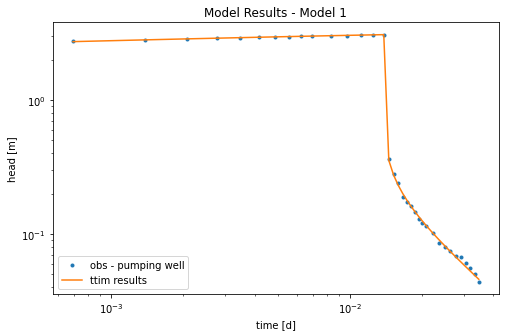

In [8]:
hm1 = w1.headinside(t)
plt.figure(figsize=(8, 5))
plt.loglog(t, -h, '.', label='obs - pumping well')
plt.loglog(t, -hm1[0], label='ttim results')
plt.xlabel('time [d]')
plt.ylabel('head [m]')
plt.legend()
plt.title("Model Results - Model 1");

Overall a good fit has been observed. We will test the results with wellbore storage

## Step 6. Alternative model with wellbore storage

Additionally to the parameters in the previous model, we add the ```rc``` parameter in the well. It is the radius of the caisson of the well, and TTim uses it to calculate the water storage in the well

In [9]:
ml2 = ModelMaq(kaq=[50, 40], z=[0, zt, zb, -68, -88], c=[1000, 1000], Saq=[1e-4, 5e-5],\
              topboundary='semi', tmin=1e-4, tmax=0.04)
w2 = Well(ml2, xw=0, yw=0, rw=rw, rc=0.155, res=1, tsandQ=[(0, Q), (t0, 0)], layers=0)
ml2.solve()

self.neq  1
solution complete


## Step 7. Calibrate the alternative model

Additionally, we also calibrate the rc parameter in the well:

In [10]:
ca2 = Calibrate(ml2)
ca2.set_parameter(name='kaq0', initial=50, pmin=0)
ca2.set_parameter(name='Saq0', initial=1e-4, pmin=0)
ca2.set_parameter_by_reference(name='rc', parameter=w2.rc[:], initial=0.1, pmin=0)
ca2.set_parameter_by_reference(name='res', parameter=w2.res[:], initial=1, pmin=0)
ca2.seriesinwell(name='obs', element=w2, t=t, h=h)
ca2.fit()

................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 573
    # data points      = 35
    # variables        = 4
    chi-square         = 0.00106334
    reduced chi-square = 3.4301e-05
    Akaike info crit   = -356.058972
    Bayesian info crit = -349.837580
[[Variables]]
    kaq0:  44.5322775 +/- 0.99969014 (2.24%) (init = 50)
    Saq0:  6.3928e-06 +/- 1.0629e-06 (16.63%) (init = 0

In [11]:
display(ca2.parameters)
print('RMSE:', ca2.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,44.532277,0.999690,2.244866,0,inf,50,[44.5322774989901]
Saq0,0.000006,0.000001,16.625756,0,inf,0.0001,[6.392843512337265e-06]
rc,0.004585,0.454788,9918.367332,0,inf,0.1,[0.0045853140190308395]
res,0.016207,0.000785,4.840922,0,inf,1,[0.016206990038743596]


RMSE: 0.005511918881910666


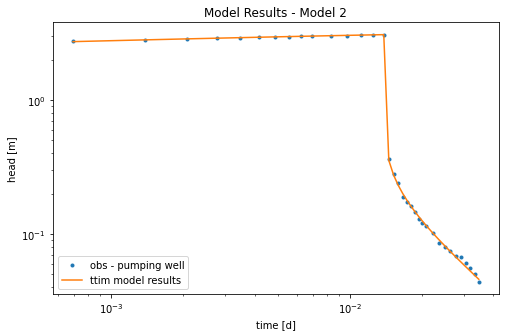

In [12]:
hm2 = w2.headinside(t)
plt.figure(figsize=(8, 5))
plt.loglog(t, -h, '.', label='obs - pumping well')
plt.loglog(t, -hm2[0], label='ttim model results')
plt.xlabel('time [d]')
plt.ylabel('head [m]')
plt.legend()
plt.title("Model Results - Model 2");

Simulation with rc has slightly worse performance. The Akaike and Bayes criteria are somewhat worse than with the previous model.

## Step 8. Testing single layer model

In this final model, we will test the assumption that we can ignore the underlying aquifer. Thus, we only worry about the upper aquifer, where water is pumped.

Therefore the last model is a single layer semi-confined aquifer that only includes the top aquitard and the first aquifer. In the well, we are not considering the ```rc``` parameter.

In [13]:
ml0 = ModelMaq(kaq=50, z=[0, zt, zb], c=1000, Saq=1e-4, topboundary='semi', \
              tmin=1e-4, tmax=0.04)
w0 = Well(ml0, xw=0, yw=0, rw=rw, res=1, tsandQ=[(0, Q), (t0, 0)], layers=0)
ml0.solve()

self.neq  1
solution complete


### Step 8.1. Calibration

In the calibration we repeat the procedure for model 1.

In [14]:
ca0 = Calibrate(ml0)
ca0.set_parameter(name='kaq0', initial=50, pmin=0)
ca0.set_parameter(name='Saq0', initial=1e-4, pmin=0)
ca0.set_parameter_by_reference(name='res', parameter=w0.res[:], initial=1)
ca0.seriesinwell(name='obs', element=w0, t=t, h=h)
ca0.fit()

......................................................................................................................................................................................................................................................................................................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 307
    # data points      = 35
    # variables        = 3
    chi-square         = 0.00106438
    reduced chi-square = 3.3262e-05
    Akaike info crit   = -358.024761
    Bayesian info crit = -353.358717
[[Variables]]
    kaq0:  44.5516140 +/- 0.65533645 (1.47%) (init = 50)
    Saq0:  3.2314e-06 +/- 4.9282e-07 (15.25%) (init = 0.0001)
    res:   0.01502951 +/- 5.9465e-04 (3.96%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0, res)  =  0.977
    C(Saq0, res)  =  0.948
    C(kaq0, Saq0) =  0.861


In [15]:
display(ca0.parameters)
print('RMSE:', ca0.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,44.551614,6.553365e-01,1.47096,0,inf,50,[44.55161399621271]
Saq0,0.000003,4.928237e-07,15.251308,0,inf,0.0001,[3.231353431054629e-06]
res,0.01503,5.946511e-04,3.956557,-inf,inf,1,[0.015029508743142891]


RMSE: 0.005514613406867893


Text(0.5, 1.0, 'Model Results - Model 3')

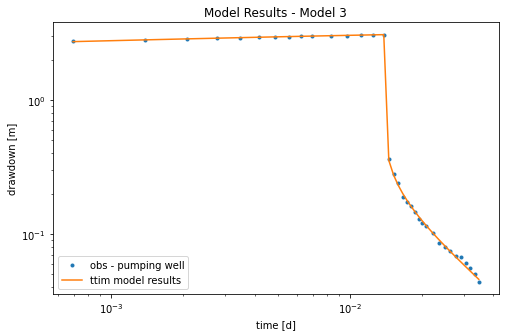

In [16]:
hm = w0.headinside(t)
plt.figure(figsize=(8, 5))
plt.loglog(t, -h, '.', label='obs - pumping well')
plt.loglog(t, -hm[0], label='ttim model results')
plt.xlabel('time [d]')
plt.ylabel('drawdown [m]')
plt.legend()
plt.title("Model Results - Model 3")

## Step 9. Consider Log-curve-fitting

The example reported in the MLU documentation (Carslon & Randall, 2012) uses curve-fitting of log-drawdowns, besides linear curve-fitting. The use of log-curve-fitting can help the fitting when observed errors are not independent of the observations. We will apply log-curve-fitting in TTim to reproduce the methodology from MLU.

For the new calibration, we use the ```fitm``` script, which has an implementation of the log-curve fitting. The original objective function is ```h_observed - h_predicted```, while for the log curve fitting, the objective function has been changed to ```log(abs(h_observed-h_predicted))```.

In [17]:
from fitm import Calibrate

In [18]:
ml3 = ModelMaq(kaq=[50, 40], z=[0, zt, zb, -68, -88], c=[1000, 1000], Saq=[1e-4, 5e-5],\
              topboundary='semi', tmin=1e-4, tmax=0.04)
w3 = Well(ml3, xw=0, yw=0, rw=rw, res=1, tsandQ=[(0, Q), (t0, 0)], layers=0)
ml3.solve()

self.neq  1
solution complete


In [19]:
ca3 = Calibrate(ml3)
ca3.set_parameter(name='kaq0', initial=50, pmin=0)
ca3.set_parameter(name='Saq0', initial=1e-4, pmin=0)
ca3.set_parameter_by_reference(name='res', parameter=w3.res[:], initial=1, pmin=0)
ca3.seriesinwell(name='obs', element=w3, t=t, h=h)
ca3.fit()

...............................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 44
    # data points      = 35
    # variables        = 3
    chi-square         = 423.133174
    reduced chi-square = 13.2229117
    Akaike info crit   = 93.2318615
    Bayesian info crit = 97.8979057
[[Variables]]
    kaq0:  46.5775700 +/- 5.25395341 (11.28%) (init = 50)
    Saq0:  6.7883e-05 +/- 7.5775e-04 (1116.27%) (init = 0.0001)
    res:   0.00723010 +/- 0.02440774 (337.58%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0, Saq0) =  0.936
    C(Saq0, res)  =  0.842
    C(kaq0, res)  =  0.799


In [20]:
display(ca3.parameters)
print('RMSE:', ca3.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,46.57757,5.253953,11.280008,0,inf,50,[46.57756996233315]
Saq0,0.000068,0.000758,1116.265628,0,inf,0.0001,[6.788282070635532e-05]
res,0.00723,0.024408,337.584942,0,inf,1,[0.00723010336653207]


RMSE: 3.4769986006316445


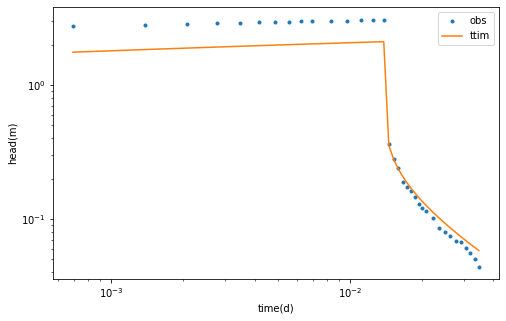

In [21]:
hm3 = w3.headinside(t)
plt.figure(figsize=(8, 5))
plt.loglog(t, -h, '.', label='obs')
plt.loglog(t, -hm3[0], label='ttim')
plt.xlabel('time(d)')
plt.ylabel('head(m)')
plt.legend();

According to RMSE and the Akaike criteria, the log curve fitting solution performs worse than linear curve fitting. The results reported in the following table are from models calibrated by linear curve fitting solution.

## Step 10. Analysis and summary of values modeled by different methods

In [22]:
ta = pd.DataFrame(columns=['k [m/d]', 'Ss [1/m]', 'res'], \
                 index=['MLU-log', 'TTim-single layer', 'TTim-two layers'])
ta.loc['TTim-single layer'] = ca0.parameters['optimal'].values
ta.loc['TTim-two layers'] = ca1.parameters['optimal'].values
ta.loc['MLU-log'] = [51.530, 8.16E-04, 0.022]
ta['RMSE [m]'] = [0.00756, ca0.rmse(), ca1.rmse()]
ta

,k [m/d],Ss [1/m],res,RMSE [m]
MLU-log,51.53,0.000816,0.022,0.007560
TTim-single layer,44.551614,0.000003,0.01503,0.005515
TTim-two layers,44.528766,0.000006,0.016205,0.005512


Both TTim models agree with each other with similar parameters. MLU adjusted parameters are higher than the ones in TTim.

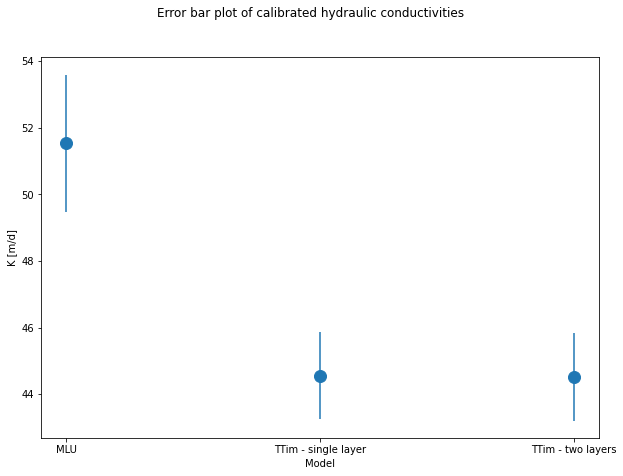

In [23]:
# Preparing the DataFrame:
t1 = pd.DataFrame(columns=['kaq - opt', 'kaq - 95%'], index = ['MLU','TTim - single layer','TTim - two layers']) 

t1.loc['MLU'] = [51.53, 4*1e-2*51.53]
t1.loc['TTim - single layer'] = [ca0.parameters.loc['kaq0','optimal'],2*ca0.parameters.loc['kaq0','std']]
t1.loc['TTim - two layers'] = [ca1.parameters.loc['kaq0','optimal'],2*ca1.parameters.loc['kaq0','std']]

# Plotting

plt.figure(figsize = (10,7))

plt.errorbar(x = t1.index, y = t1['kaq - opt'], yerr = [t1['kaq - 95%'], t1['kaq - 95%']],
    marker='o', linestyle='', markersize=12)
#plt.legend()
plt.suptitle("Error bar plot of calibrated hydraulic conductivities")
plt.ylabel('K [m/d]')
#plt.ylim([36,40])
plt.xlabel('Model');

Comparing the adjusted error bars for hydraulic conductivities for our models, we see that the TTim models do not overlap the MLU range.

## References

* Carlson F, Randall J (2012) MLU: a Windows application for the analysis of aquifer tests and the design of well fields in layered systems. Ground Water 50(4):504–510
* Duffield, G.M., 2007. AQTESOLV for Windows Version 4.5 User's Guide, HydroSOLVE, Inc., Reston, VA.
* Newville, M.,Stensitzki, T., Allen, D.B., Ingargiola, A. (2014) LMFIT: Non Linear Least-Squares Minimization and Curve Fitting for Python.https://dx.doi.org/10.5281/zenodo.11813. https://lmfit.github.io/lmfit-py/intro.html (last access: August,2021).
* Yang, Xinzhu (2020) Application and comparison of different methodsfor aquifer test analysis using TTim. Master Thesis, Delft University of Technology (TUDelft), Delft, The Netherlands.

#### Next Notebook: [Leaky 3 - Texas Hill](leaky3_texashill.ipynb)